In [8]:
import pandas as pd
import sys
import os
import importlib
import subprocess

# Verificar e instalar optuna si es necesario
try:
    import optuna
    print("✅ Optuna ya está instalado")
    print(f"   Versión: {optuna.__version__}")
except ImportError:
    print("⚠️ Optuna no está instalado. Instalando...")
    print(f"   Python ejecutable: {sys.executable}")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "optuna"])
    import optuna
    print("✅ Optuna instalado correctamente")
    print(f"   Versión: {optuna.__version__}")

# Mostrar información del entorno (útil para debugging)
print(f"\n📋 Información del entorno:")
print(f"   Python: {sys.executable}")
print(f"   Versión Python: {sys.version.split()[0]}")

from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score

# Configurar el path para poder importar tools
# El notebook está en ENTREGABLES/marcos/, necesitamos subir un nivel a ENTREGABLES/
current_dir = os.getcwd()
# Si estamos en marcos/, subir un nivel
if current_dir.endswith('marcos'):
    entregables_dir = os.path.dirname(current_dir)
else:
    # Si no, buscar el directorio ENTREGABLES en el path actual
    entregables_dir = current_dir
    while not os.path.exists(os.path.join(entregables_dir, 'tools.py')):
        parent = os.path.dirname(entregables_dir)
        if parent == entregables_dir:  # Llegamos a la raíz
            break
        entregables_dir = parent

if os.path.exists(os.path.join(entregables_dir, 'tools.py')):
    if entregables_dir not in sys.path:
        sys.path.insert(0, entregables_dir)
    print(f"✅ Path configurado: {entregables_dir}")
else:
    print("⚠️ No se encontró el archivo tools.py. Verifica la estructura del proyecto.")

# Importar y recargar el módulo tools para asegurar que tenemos la versión más reciente
import tools
importlib.reload(tools)  # Recargar el módulo para obtener los cambios más recientes
from tools import (
    seleccionar_variables, 
    plot_costo_interactivo, 
    evaluate_model_with_thresholds, 
    evaluate_model,
    optimizar_threshold_costo_cv,
    optimizar_threshold_f1_cv
)

print("✅ Módulo tools recargado e importado correctamente")



✅ Optuna ya está instalado
   Versión: 4.6.0

📋 Información del entorno:
   Python: c:\Users\marca\anaconda3\python.exe
   Versión Python: 3.13.5
✅ Path configurado: c:\Users\marca\OneDrive\AUSTRAL\2do año\2do cuat\TRP II\mercado-libre-fraude-2025\ENTREGABLES
✅ Módulo tools recargado e importado correctamente


In [9]:
df = pd.read_csv("../../DATA/processed/fraud_dataset_processed.csv")

df = seleccionar_variables(
    df,
    categoria_encoding=True, 
    pais_encoding=True,
    o_dummies=True,
    producto_nombre_encoding=True,
    fecha_encoding=3,
    remove_r = True,
    remove_d=True,
    remove_score=True
    )

In [10]:
# ============================================================================
# OPTIMIZACIÓN DE HIPERPARÁMETROS CON OPTUNA
# ============================================================================

import numpy as np
import joblib

print("=" * 80)
print("OPTIMIZACIÓN DE HIPERPARÁMETROS CON OPTUNA")
print("=" * 80)

# Preparar variables predictoras y target
X = df.drop(columns=['fraude'])
y = df['fraude']

# Split en train/test (usaremos solo train para optimización)
X_train_opt, X_test_opt, y_train_opt, y_test_opt = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Parámetros de costo
costo_fp = 5.0
costo_fn = 100.0

# Convertir a arrays numpy una sola vez (fuera de la función objetivo)
X_train_array = np.array(X_train_opt)
y_train_array = np.array(y_train_opt)

# Configurar Cross-Validation para optimización
cv_opt = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def objetivo(trial):
    """
    Función objetivo para Optuna que minimiza el costo por 1000 registros.
    """
    # Sugerir hiperparámetros
    n_estimators = trial.suggest_int('n_estimators', 100, 600, step=50)
    max_depth = trial.suggest_int('max_depth', 5, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    
    # Parámetros específicos de BalancedRandomForestClassifier
    sampling_strategy = trial.suggest_float('sampling_strategy', 0.3, 1.0)
    replacement = trial.suggest_categorical('replacement', [True, False])
    
    # Crear modelo con los hiperparámetros sugeridos
    model = BalancedRandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        sampling_strategy=sampling_strategy,
        replacement=replacement,
        random_state=42,
        n_jobs=-1
    )
    
    # Calcular costo promedio en CV
    costos = []
    for train_idx, val_idx in cv_opt.split(X_train_array, y_train_array):
        # Entrenar modelo
        model.fit(X_train_array[train_idx], y_train_array[train_idx])
        
        # Predecir probabilidades
        y_proba = model.predict_proba(X_train_array[val_idx])[:, 1]
        
        # Calcular costo para diferentes thresholds y encontrar el mínimo
        # Usamos un rango de thresholds para encontrar el óptimo
        thresholds = np.linspace(0.1, 0.9, 30)
        costo_minimo_fold = float('inf')
        
        for threshold in thresholds:
            y_pred = (y_proba >= threshold).astype(int)
            
            # Calcular matriz de confusión
            from sklearn.metrics import confusion_matrix
            cm = confusion_matrix(y_train_array[val_idx], y_pred)
            
            if cm.size == 4:
                tn, fp, fn, tp = cm.ravel()
                
                # Calcular costo por 1000 registros
                n_total = len(y_pred)
                costo_total = (fp * costo_fp + fn * costo_fn)
                costo_por_1000 = (costo_total / n_total) * 1000
                
                if costo_por_1000 < costo_minimo_fold:
                    costo_minimo_fold = costo_por_1000
        
        costos.append(costo_minimo_fold)
    
    # Retornar costo promedio
    return np.mean(costos)

# Configurar logging detallado de Optuna
optuna.logging.set_verbosity(optuna.logging.INFO)

# Crear estudio de Optuna
print("\n🔍 Iniciando optimización de hiperparámetros...")
print("   Esto puede tomar varios minutos...")

study = optuna.create_study(
    direction='minimize',  # Minimizar el costo
    study_name='brf_optimization',
    sampler=optuna.samplers.TPESampler(seed=42)
)

# Ejecutar optimización (50 trials por defecto, se puede ajustar)
study.optimize(objetivo, n_trials=50, show_progress_bar=True)

# Mostrar mejores parámetros
print("\n" + "=" * 80)
print("MEJORES HIPERPARÁMETROS ENCONTRADOS:")
print("=" * 80)
print(f"   Costo mínimo por 1000 registros: {study.best_value:.2f}")
print(f"\n   Parámetros óptimos:")
for key, value in study.best_params.items():
    print(f"   - {key}: {value}")

# Guardar mejores parámetros para usar en el modelo final
best_params = study.best_params.copy()
best_params['random_state'] = 42
best_params['n_jobs'] = -1

# Visualizaciones del estudio
print("\n" + "=" * 80)
print("VISUALIZACIONES DEL ESTUDIO")
print("=" * 80)

# Historial de optimización
print("\n📈 Historial de optimización:")
fig_history = optuna.visualization.plot_optimization_history(study)
fig_history.show()

# Importancia de parámetros
print("\n📊 Importancia de parámetros:")
fig_importance = optuna.visualization.plot_param_importances(study)
fig_importance.show()

# Guardar el estudio completo con joblib
study_path = 'optuna_study_brf.pkl'
joblib.dump(study, study_path)
print(f"\n💾 Estudio guardado en: {study_path}")

print("\n✅ Optimización completada")


OPTIMIZACIÓN DE HIPERPARÁMETROS CON OPTUNA


[I 2025-11-13 15:40:37,554] A new study created in memory with name: brf_optimization



🔍 Iniciando optimización de hiperparámetros...
   Esto puede tomar varios minutos...


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-11-13 15:41:45,211] Trial 0 finished with value: 832.25 and parameters: {'n_estimators': 300, 'max_depth': 20, 'min_samples_split': 15, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'sampling_strategy': 0.9063233020424546, 'replacement': False}. Best is trial 0 with value: 832.25.
[I 2025-11-13 15:42:45,602] Trial 1 finished with value: 840.425 and parameters: {'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 17, 'min_samples_leaf': 3, 'max_features': None, 'sampling_strategy': 0.6673295021425665, 'replacement': True}. Best is trial 0 with value: 832.25.
[I 2025-11-13 15:43:54,391] Trial 2 finished with value: 879.8 and parameters: {'n_estimators': 400, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': 'log2', 'sampling_strategy': 0.6599641068895281, 'replacement': True}. Best is trial 0 with value: 832.25.
[I 2025-11-13 15:45:16,884] Trial 3 finished with value: 911.35 and parameters: {'n_estimators': 400, 'max_depth': 7, 'min_samples_sp


📊 Importancia de parámetros:



💾 Estudio guardado en: optuna_study_brf.pkl

✅ Optimización completada


In [11]:
# ============================================================================
# PIPELINE COMPLETO DEL MODELO
# ============================================================================
# 1. Preparar datos
# 2. Entrenar modelos (uno con CV para optimizar thresholds, otro con todos los datos)
# 3. Optimizar thresholds (costo y F1) con CV
# 4. Evaluar modelo con ambos thresholds
# ============================================================================

# Usar los datos ya divididos de la optimización
X_train = X_train_opt
X_test = X_test_opt
y_train = y_train_opt
y_test = y_test_opt

print("=" * 80)
print("PASO 1: ENTRENAR MODELOS CON HIPERPARÁMETROS OPTIMIZADOS")
print("=" * 80)

# Configurar Balanced Random Forest con hiperparámetros optimizados
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import StratifiedKFold

rf_cv = BalancedRandomForestClassifier(**best_params)
rf_final = BalancedRandomForestClassifier(**best_params)

# Configurar Cross-Validation (5 folds estratificados)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("\n✅ Modelos configurados con hiperparámetros optimizados:")
print(f"   - rf_cv: Para optimización de thresholds con CV")
print(f"   - rf_final: Para evaluación final con todos los datos de entrenamiento")
print(f"\n📋 Hiperparámetros utilizados:")
for key, value in best_params.items():
    if key not in ['random_state', 'n_jobs']:
        print(f"   - {key}: {value}")

# Entrenar modelo final con todos los datos de entrenamiento (para evaluación)
print(f"\n🎯 Entrenando modelo final con todos los datos de entrenamiento...")
rf_final.fit(X_train, y_train)

# Predicciones en el conjunto de test
y_proba_test = rf_final.predict_proba(X_test)[:, 1]

print(f"\n✅ Modelo final entrenado")
print(f"   - Probabilidades en test: {len(y_proba_test)} muestras")



PASO 1: ENTRENAR MODELOS CON HIPERPARÁMETROS OPTIMIZADOS

✅ Modelos configurados con hiperparámetros optimizados:
   - rf_cv: Para optimización de thresholds con CV
   - rf_final: Para evaluación final con todos los datos de entrenamiento

📋 Hiperparámetros utilizados:
   - n_estimators: 550
   - max_depth: 15
   - min_samples_split: 4
   - min_samples_leaf: 1
   - max_features: log2
   - sampling_strategy: 0.4553589346171797
   - replacement: True

🎯 Entrenando modelo final con todos los datos de entrenamiento...

✅ Modelo final entrenado
   - Probabilidades en test: 50000 muestras


In [12]:
# ============================================================================
# PASO 2: OPTIMIZAR THRESHOLDS CON CROSS-VALIDATION
# ============================================================================

print("=" * 80)
print("PASO 2: OPTIMIZAR THRESHOLDS CON CROSS-VALIDATION")
print("=" * 80)

# Parámetros de costo
costo_fp = 5.0
costo_fn = 100.0

# Calcular probabilidades de CV una sola vez (para evitar recalcular los folds)
print("\n📊 Calculando probabilidades con Cross-Validation...")
from sklearn.model_selection import cross_val_predict
y_proba_cv = cross_val_predict(rf_cv, X_train, y_train, cv=cv, method='predict_proba')[:, 1]
print(f"✅ Probabilidades de CV calculadas: {len(y_proba_cv)} muestras")

# Optimizar threshold por costo usando CV
print("\n🔍 Optimizando threshold por función de costo...")
resultado_costo = optimizar_threshold_costo_cv(
    model=rf_cv,
    X=X_train,
    y=y_train,
    cv=cv,
    costo_fp=costo_fp,
    costo_fn=costo_fn,
    model_name="Balanced Random Forest",
    y_proba_cv=y_proba_cv  # Reutilizar las probabilidades ya calculadas
)

threshold_optimo_costo = resultado_costo['threshold_optimo']
costo_minimo = resultado_costo['costo_minimo']

# Optimizar threshold por F1 Score usando CV
print("\n🔍 Optimizando threshold por F1 Score...")
resultado_f1 = optimizar_threshold_f1_cv(
    model=rf_cv,
    X=X_train,
    y=y_train,
    cv=cv,
    model_name="Balanced Random Forest",
    y_proba_cv=y_proba_cv  # Reutilizar las probabilidades ya calculadas
)

threshold_optimo_f1 = resultado_f1['threshold_optimo']
f1_maximo = resultado_f1['f1_maximo']

print("\n" + "=" * 80)
print("RESUMEN DE THRESHOLDS ÓPTIMOS:")
print("=" * 80)
print(f"📌 Threshold óptimo (Costo): {threshold_optimo_costo:.4f}")
print(f"   Costo mínimo: {costo_minimo:.2f} por 1000 registros")
print(f"\n📌 Threshold óptimo (F1 Score): {threshold_optimo_f1:.4f}")
print(f"   F1 Score máximo: {f1_maximo:.4f}")


PASO 2: OPTIMIZAR THRESHOLDS CON CROSS-VALIDATION

📊 Calculando probabilidades con Cross-Validation...
✅ Probabilidades de CV calculadas: 200000 muestras

🔍 Optimizando threshold por función de costo...

🎯 OPTIMIZACIÓN DE THRESHOLD POR COSTO (CV):
   Threshold óptimo: 0.4021
   Costo mínimo por 1000 registros: 813.80
   FP ajustado: 17192
   FN ajustado: 768

📊 EVALUACIÓN DE ROBUSTEZ:
   Coeficiente de variación (CV): 0.0359
   Robustez: Muy robusto ✅
   Costo medio por fold: 813.80 ± 29.19

🔍 Optimizando threshold por F1 Score...

🎯 OPTIMIZACIÓN DE THRESHOLD POR F1 SCORE (CV):
   Threshold óptimo: 0.7487
   F1 Score máximo: 0.5365
   Precision: 0.5037
   Recall: 0.5740

📊 EVALUACIÓN DE ROBUSTEZ:
   Coeficiente de variación (CV): 0.0181
   Robustez: Muy robusto ✅
   F1 Score medio por fold: 0.5365 ± 0.0097

RESUMEN DE THRESHOLDS ÓPTIMOS:
📌 Threshold óptimo (Costo): 0.4021
   Costo mínimo: 813.80 por 1000 registros

📌 Threshold óptimo (F1 Score): 0.7487
   F1 Score máximo: 0.5365


PASO 3: EVALUAR MODELO CON THRESHOLDS ÓPTIMOS

EVALUACIÓN CON THRESHOLD ÓPTIMO (COSTO)
EVALUACIÓN DEL MODELO: Balanced Random Forest - Threshold Costo (0.4021)

📌 Threshold usado: 0.4021

📊 DISTRIBUCIÓN DE CLASES:
   Clase 0 (No Fraude): 48,500 (97.00%)
   Clase 1 (Fraude):    1,500 (3.00%)
   Total:               50,000

🎯 MÉTRICAS PRINCIPALES:
   Accuracy:            0.9114
   F1 Score:            0.3703 ⭐
   Precision:           0.2353
   Recall (Sensitivity): 0.8687
   Specificity:         0.9127
   ROC AUC:             0.9569
   Average Precision:   0.5587

📈 MÉTRICAS ADICIONALES:
   Cohen's Kappa:       0.3391
   Matthews Corr Coef:  0.4248
   NPV:                 0.9956
   False Positive Rate: 0.0873

📊 RESUMEN DE MÉTRICAS CLAVE:
   Precision:          0.2353
   Recall:             0.8687
   F1 Score:           0.3703
   Cohen's Kappa:      0.3391
   Matthews Corr Coef: 0.4248
   Tasa positivos:     0.1107

💰 COSTO:
   Costo por 1000 registros: 817.40
   (Costo FP: 5.0, Costo FN

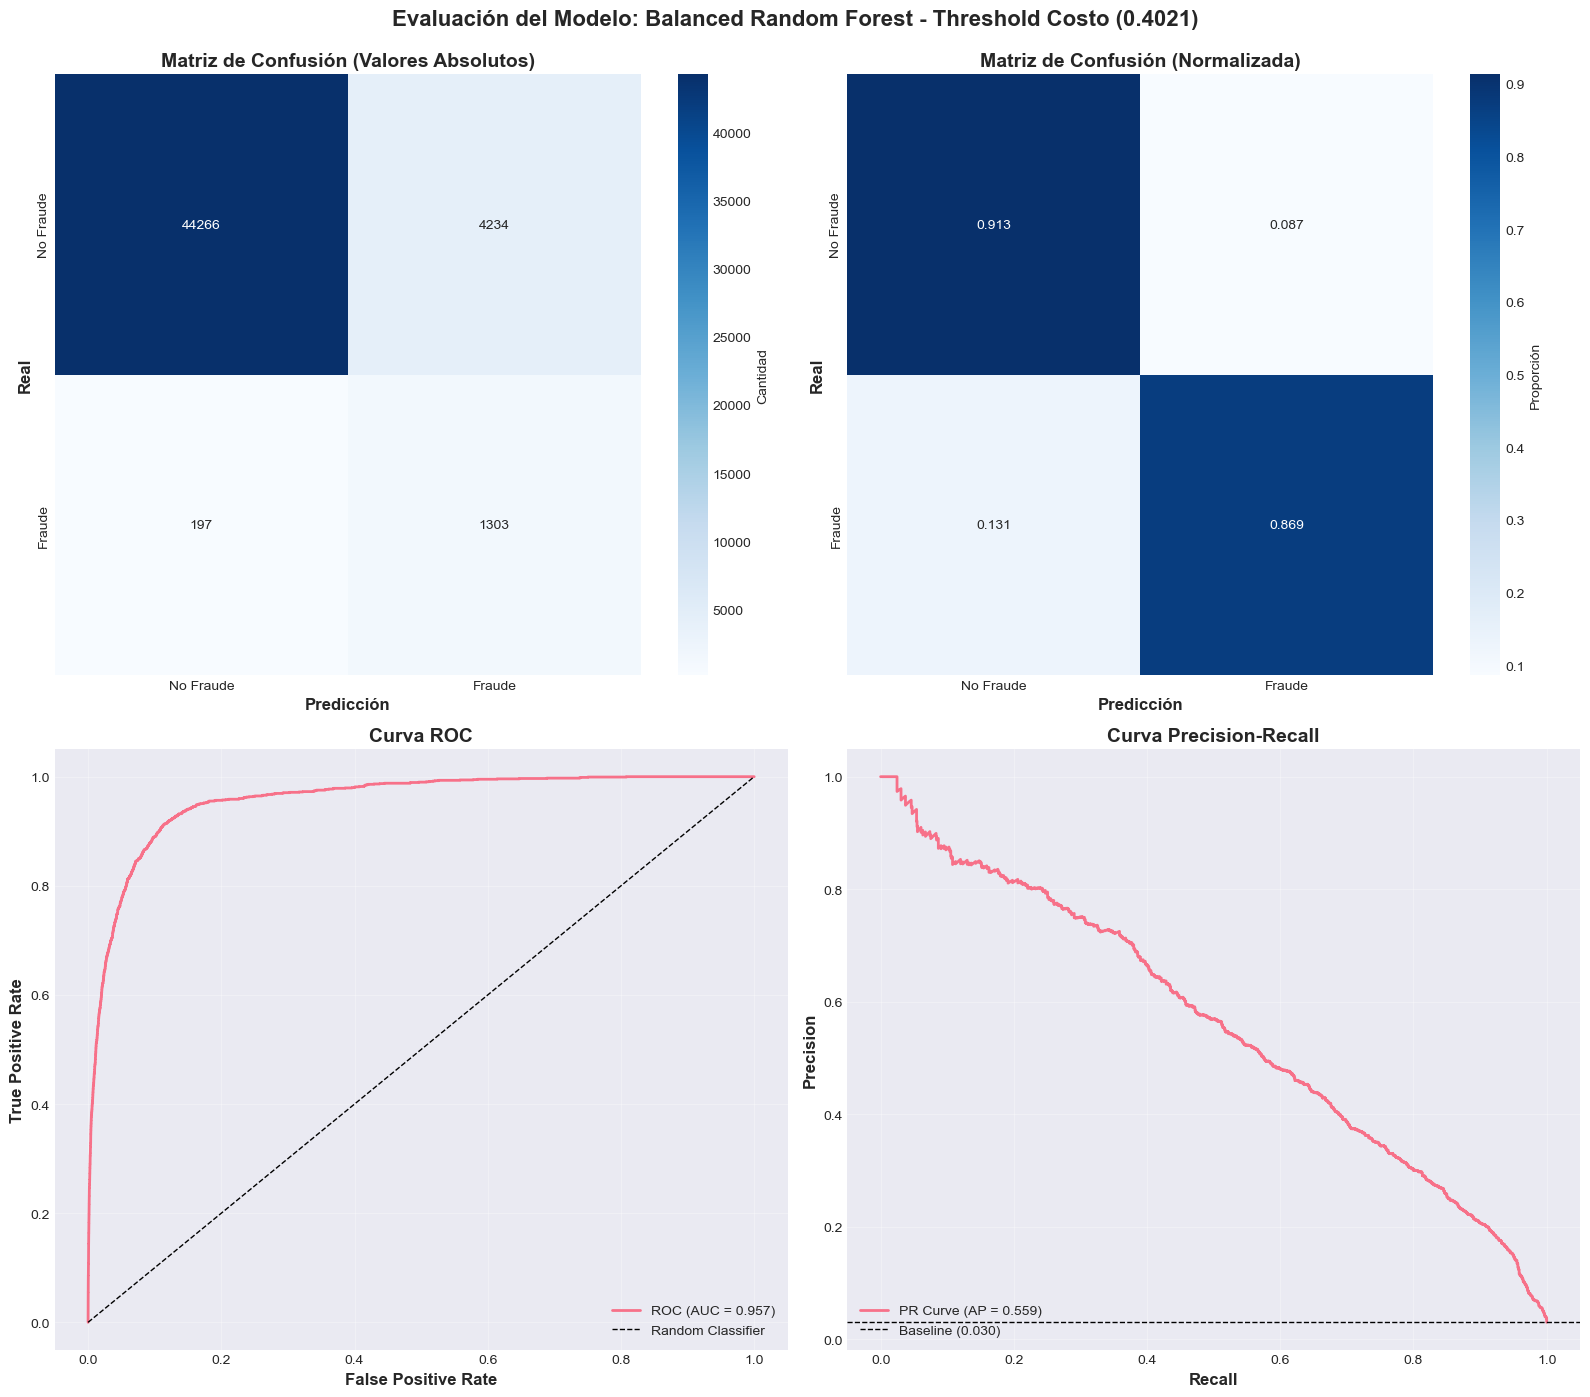

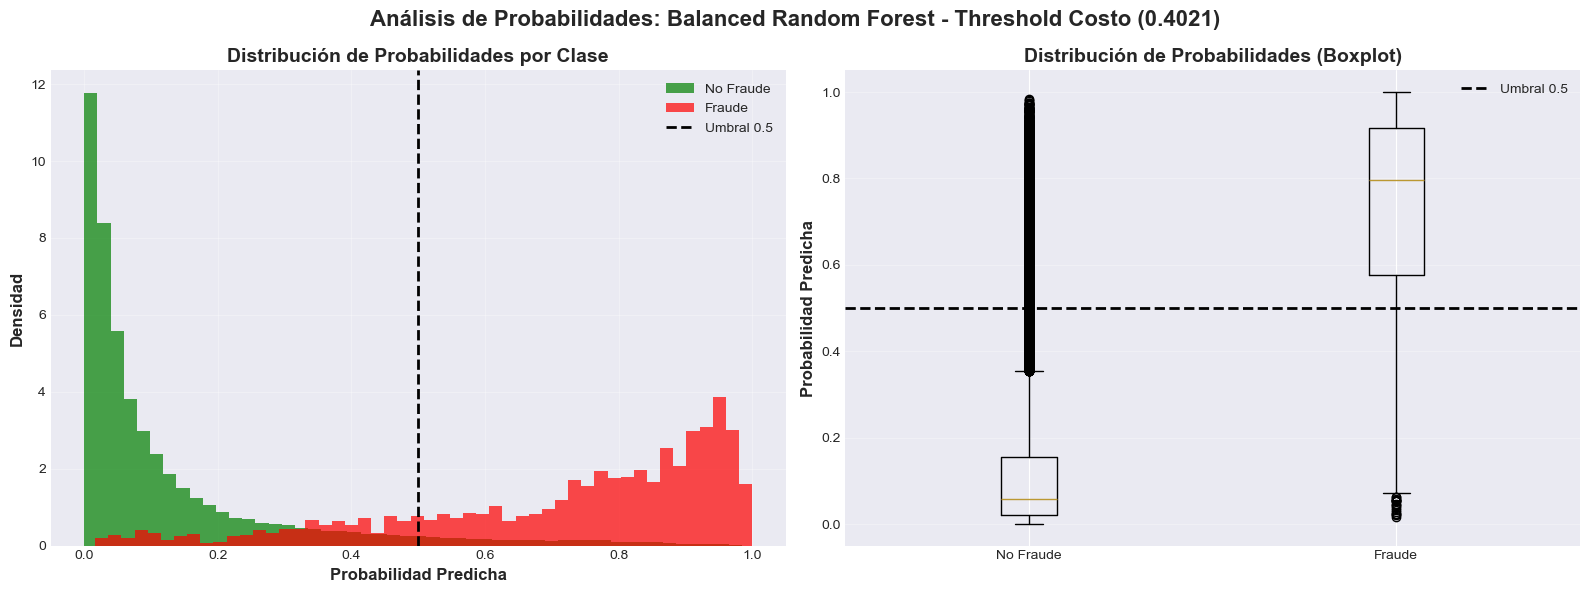


EVALUACIÓN CON THRESHOLD ÓPTIMO (F1 SCORE)
EVALUACIÓN DEL MODELO: Balanced Random Forest - Threshold F1 (0.7487)

📌 Threshold usado: 0.7487

📊 DISTRIBUCIÓN DE CLASES:
   Clase 0 (No Fraude): 48,500 (97.00%)
   Clase 1 (Fraude):    1,500 (3.00%)
   Total:               50,000

🎯 MÉTRICAS PRINCIPALES:
   Accuracy:            0.9697
   F1 Score:            0.5337 ⭐
   Precision:           0.4957
   Recall (Sensitivity): 0.5780
   Specificity:         0.9818
   ROC AUC:             0.9569
   Average Precision:   0.5587

📈 MÉTRICAS ADICIONALES:
   Cohen's Kappa:       0.5181
   Matthews Corr Coef:  0.5198
   NPV:                 0.9869
   False Positive Rate: 0.0182

📊 RESUMEN DE MÉTRICAS CLAVE:
   Precision:          0.4957
   Recall:             0.5780
   F1 Score:           0.5337
   Cohen's Kappa:      0.5181
   Matthews Corr Coef: 0.5198
   Tasa positivos:     0.0350

💰 COSTO:
   Costo por 1000 registros: 1354.20
   (Costo FP: 5.0, Costo FN: 100.0)

🔢 MATRIZ DE CONFUSIÓN:
            

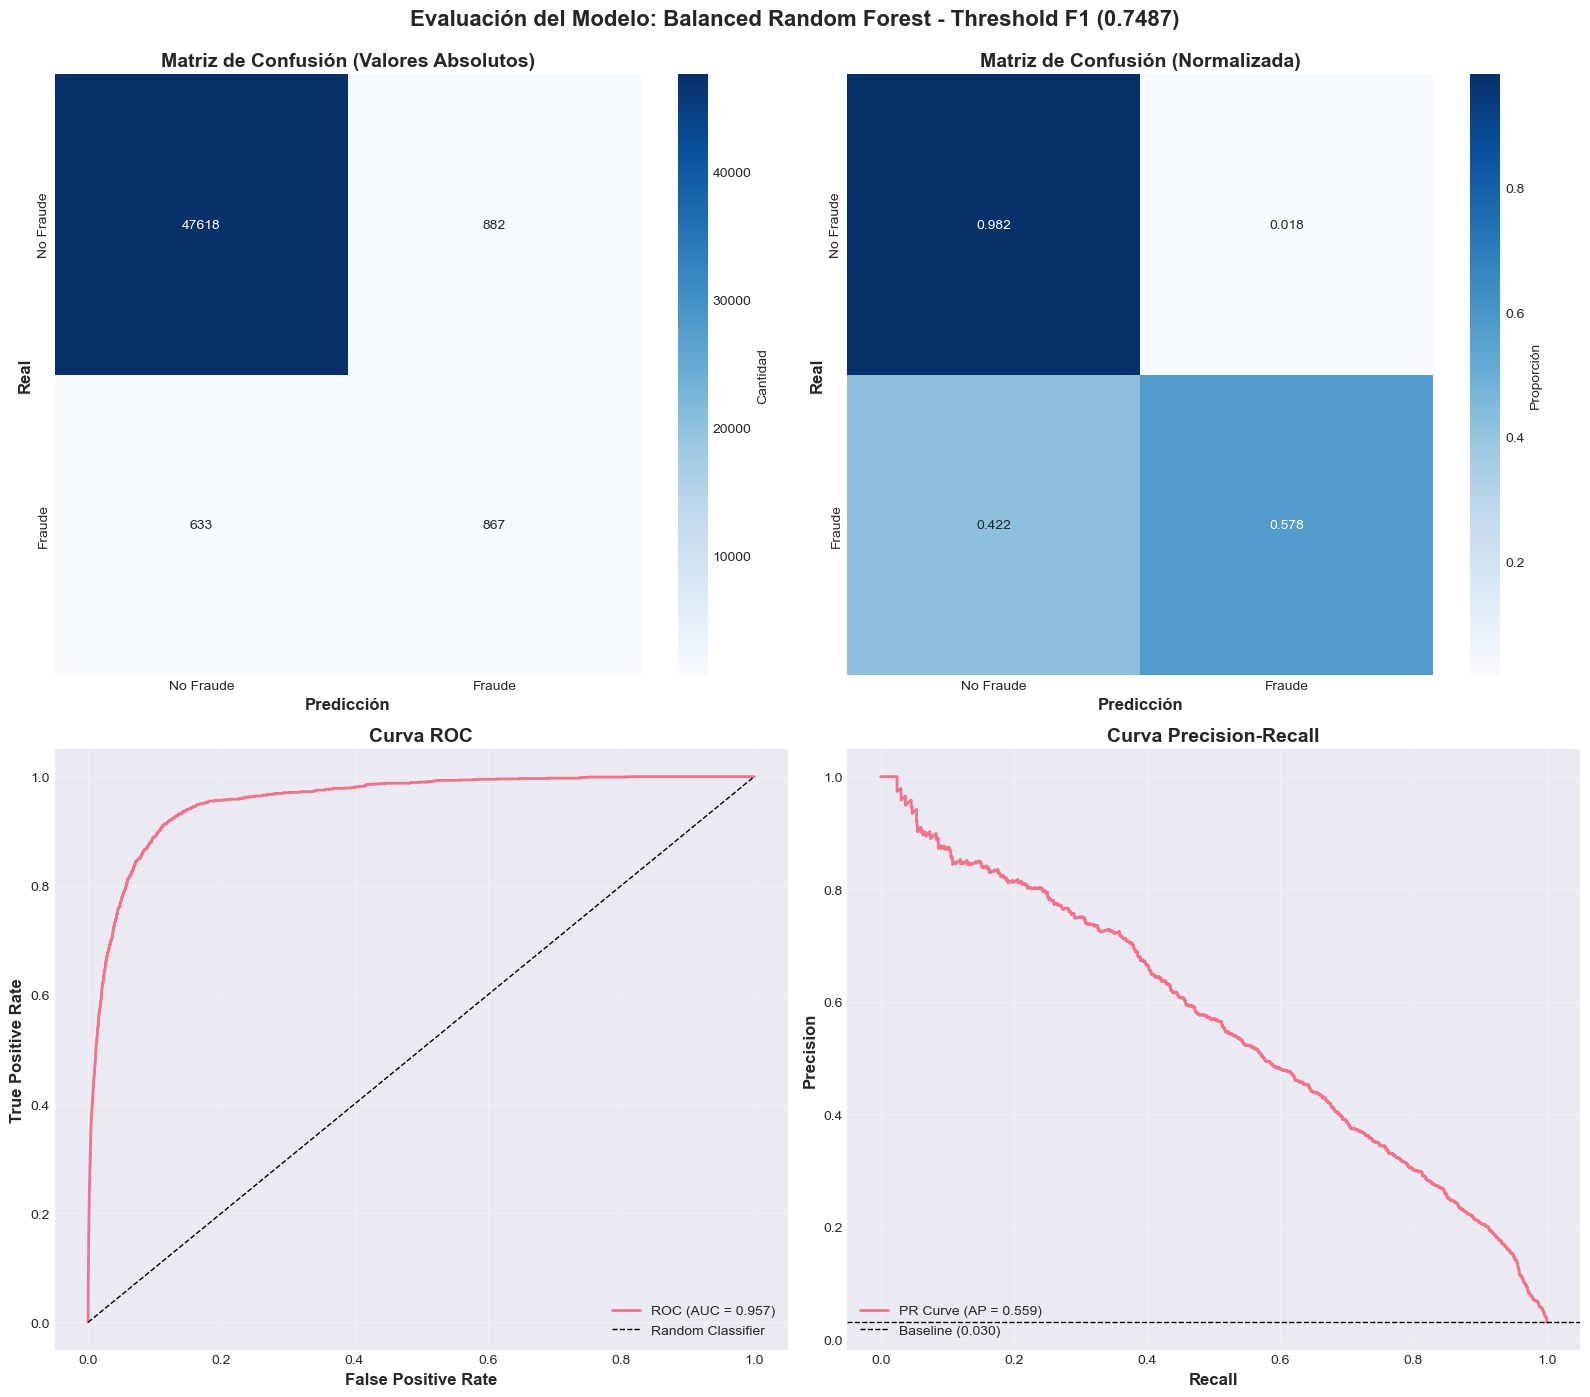

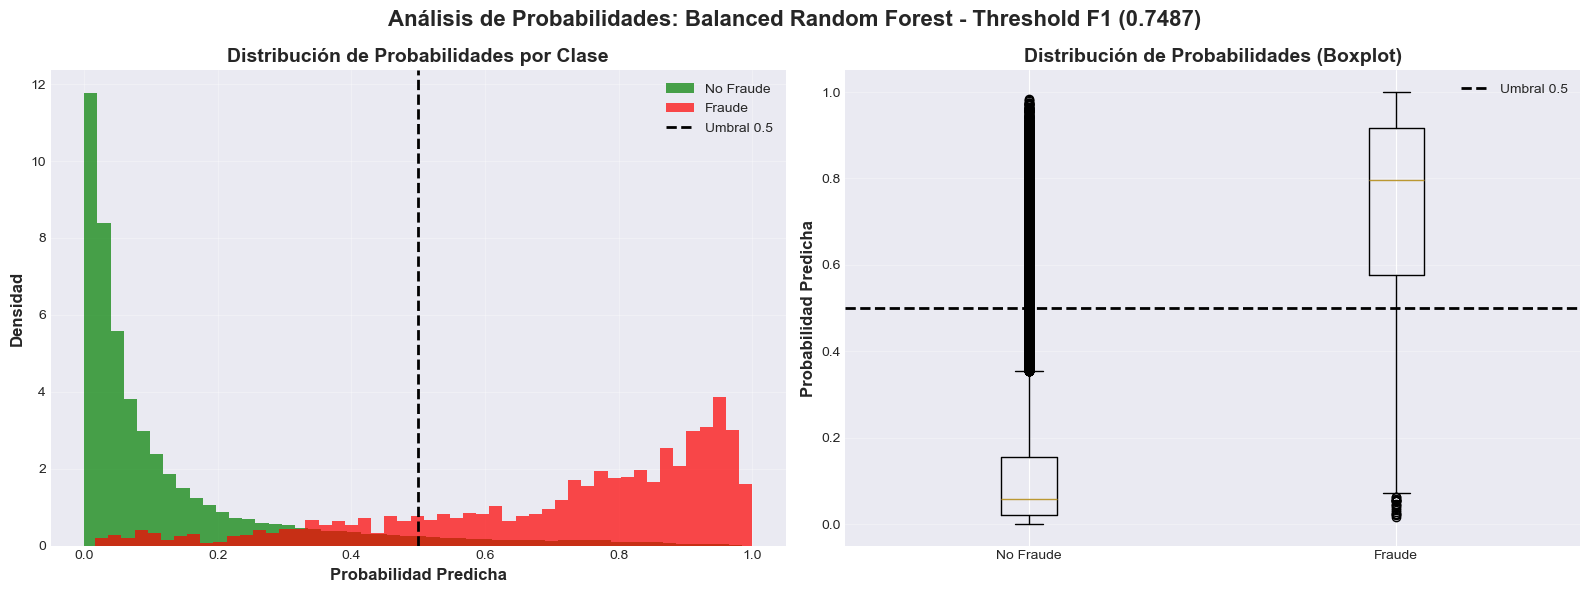

In [13]:
# ============================================================================
# PASO 3: EVALUAR MODELO CON AMBOS THRESHOLDS
# ============================================================================

print("=" * 80)
print("PASO 3: EVALUAR MODELO CON THRESHOLDS ÓPTIMOS")
print("=" * 80)

# Evaluar con threshold óptimo de costo
print("\n" + "=" * 80)
print("EVALUACIÓN CON THRESHOLD ÓPTIMO (COSTO)")
print("=" * 80)

metrics_costo = evaluate_model(
    y_true=y_test,
    y_proba=y_proba_test,
    threshold=threshold_optimo_costo,
    model_name=f"Balanced Random Forest - Threshold Costo ({threshold_optimo_costo:.4f})",
    costo_fp=costo_fp,
    costo_fn=costo_fn
)

# Evaluar con threshold óptimo de F1
print("\n" + "=" * 80)
print("EVALUACIÓN CON THRESHOLD ÓPTIMO (F1 SCORE)")
print("=" * 80)

metrics_f1 = evaluate_model(
    y_true=y_test,
    y_proba=y_proba_test,
    threshold=threshold_optimo_f1,
    model_name=f"Balanced Random Forest - Threshold F1 ({threshold_optimo_f1:.4f})",
    costo_fp=costo_fp,
    costo_fn=costo_fn
)


In [14]:
# ============================================================================
# IMPORTANCIA DE VARIABLES
# ============================================================================

print("=" * 80)
print("IMPORTANCIA DE VARIABLES (Ordenadas de mayor a menor)")
print("=" * 80)

# Obtener importancias del modelo final
importancias = rf_final.feature_importances_
variables = X_train.columns

# Crear DataFrame con importancias
df_importancias = pd.DataFrame({
    'Variable': variables,
    'Importancia': importancias
})

# Ordenar de mayor a menor
df_importancias = df_importancias.sort_values('Importancia', ascending=False).reset_index(drop=True)

# Agregar porcentaje acumulado
df_importancias['Importancia_%'] = df_importancias['Importancia'] * 100
df_importancias['Importancia_Acumulada_%'] = df_importancias['Importancia_%'].cumsum()

# Mostrar todas las variables
print(f"\n📊 Total de variables: {len(df_importancias)}")
print(f"\n{'Rank':<6} {'Variable':<40} {'Importancia':<15} {'%':<10} {'% Acum.':<10}")
print("-" * 85)

for idx, row in df_importancias.iterrows():
    print(f"{idx+1:<6} {row['Variable']:<40} {row['Importancia']:<15.6f} {row['Importancia_%']:<10.2f} {row['Importancia_Acumulada_%']:<10.2f}")

# Mostrar top 10
print("\n" + "=" * 80)
print("TOP 10 VARIABLES MÁS IMPORTANTES:")
print("=" * 80)
print(df_importancias.head(10)[['Variable', 'Importancia', 'Importancia_%']].to_string(index=False))

# Mostrar estadísticas
print("\n" + "=" * 80)
print("ESTADÍSTICAS DE IMPORTANCIA:")
print("=" * 80)
print(f"   - Importancia máxima: {df_importancias['Importancia'].max():.6f} ({df_importancias['Importancia'].max()*100:.2f}%)")
print(f"   - Importancia mínima: {df_importancias['Importancia'].min():.6f} ({df_importancias['Importancia'].min()*100:.2f}%)")
print(f"   - Importancia media:  {df_importancias['Importancia'].mean():.6f} ({df_importancias['Importancia'].mean()*100:.2f}%)")
print(f"   - Desviación estándar: {df_importancias['Importancia'].std():.6f} ({df_importancias['Importancia'].std()*100:.2f}%)")
print(f"\n   - Variables con >1% de importancia: {(df_importancias['Importancia_%'] > 1).sum()}")
print(f"   - Variables con >0.5% de importancia: {(df_importancias['Importancia_%'] > 0.5).sum()}")
print(f"   - Variables con <0.1% de importancia: {(df_importancias['Importancia_%'] < 0.1).sum()}")


IMPORTANCIA DE VARIABLES (Ordenadas de mayor a menor)

📊 Total de variables: 35

Rank   Variable                                 Importancia     %          % Acum.   
-------------------------------------------------------------------------------------
1      producto_freq                            0.277155        27.72      27.72     
2      categoria_id_target_enc                  0.130952        13.10      40.81     
3      o_is_NA                                  0.082528        8.25       49.06     
4      o_is_N                                   0.080656        8.07       57.13     
5      l                                        0.036934        3.69       60.82     
6      f                                        0.035822        3.58       64.40     
7      m                                        0.029337        2.93       67.34     
8      c                                        0.024572        2.46       69.80     
9      b                                        0.022864   